### Accessing Google Cloud

In [2]:
import os
if 'COLAB_RELEASE_TAG' in os.environ:
  from google.colab import userdata
  import pathlib
  pathlib.Path('client_secret.json').write_text(userdata.get('CLIENT_SECRET'))

  # Use `--no-browser` in colab
  ! gcloud auth application-default login --no-browser --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.tuning'
else:
  ! gcloud auth application-default login --client-id-file client_secret.json --scopes='https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/genhttps://localhost:8085/?state=mcQSxZ7fEpDCEmGmuvbce5AC3WDKEl&code=4/0ATx3LY4IFrpxH_9Trb0wc8OD0OHg9bplnsBiTwKbVQ78BFLubZAqnCOz4jHBkeHsucXXBA&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/generative-language.tuningerative-language.tuning'

You are authorizing client libraries without access to a web browser. Please run the following command on a machine with a web browser and copy its output back here. Make sure the installed gcloud version is 372.0.0 or newer.

gcloud auth application-default login --remote-bootstrap="https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=531538982827-1g0erebqrj32s3htfqqrdoev3mpltdo7.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=wAQJ7JFeOAsjUYNCXl2d3Plas6L1FP&access_type=offline&code_challenge=KNINHRS4tu-P5JfySCd2qJwc0_HYg4M3qf3KWs_2FpU&code_challenge_method=S256&token_usage=remote"


Enter the output of the above command: https://localhost:8085/?state=wAQJ7JFeOAsjUYNCXl2d3Plas6L1FP&code=4/0ATx3LY52u_934nmrSWwVkRl3QbJU1P74dn2iL6ZY3FdQmUEeqy2E1M7r4NCig-zkawLtlw&scope=https://www.googleapis.com/auth/cloud-platform%20https://www.googleapis.com/auth/generati

### Imports

In [3]:
import time
import json
import pandas as pd
import seaborn as sns
import google.generativeai as genai
from collections import defaultdict

### Defining the Loading Function

In [4]:
# Function to load JSNOL files
def load_jsnol(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Load the subtitles file
subtitles_data = load_jsnol(r'/content/tvqa_preprocessed_subtitles.jsonl')

# Load the questions and answers file
qa_data = load_jsnol(r'/content/tvqa_train.jsonl')

### Combining the Questions and Answers of the TVQA Dataset with the Subtitles of the TVR Dataset

In [5]:
def filter_and_combine_data(subtitles_data, qa_data, show_name_prefix):
    # Create a dictionary to collect all subtitles by vid_name
    subtitles_dict = defaultdict(list)
    for item in subtitles_data:
        if item['vid_name'].startswith(show_name_prefix):
            subtitles_dict[item['vid_name']].extend(item['sub'])

    # Create combined context-QA pairs
    combined_data = defaultdict(lambda: {'context': '', 'qas': []})
    for qa in qa_data:
        if qa['vid_name'].startswith(show_name_prefix):
            vid_name = qa['vid_name']
            if vid_name in subtitles_dict:
                # Combine subtitles into a single context string
                context = " ".join([sub['text'] for sub in subtitles_dict[vid_name]])
                question = qa['q']
                answer = qa[f'a{qa["answer_idx"]}']

                combined_data[vid_name]['context'] = context
                combined_data[vid_name]['qas'].append({'question': question, 'answer': answer})

    return combined_data

# Filter and combine data for "Castle"
castle_data = filter_and_combine_data(subtitles_data, qa_data, 'castle')

# Filter and combine data for "Friends"
friends_data = filter_and_combine_data(subtitles_data, qa_data, 'friends')

# Convert to list of dictionaries
combined_castle_data = [{'vid_name': vid_name, **data} for vid_name, data in castle_data.items()]
combined_friends_data = [{'vid_name': vid_name, **data} for vid_name, data in friends_data.items()]

# Verify the number of combined context-QA pairs created
print(f"Created {len(combined_castle_data)} combined context-QA pairs for 'Castle'.")
print(f"Created {len(combined_friends_data)} combined context-QA pairs for 'Friends'.")

Created 4217 combined context-QA pairs for 'Castle'.
Created 4807 combined context-QA pairs for 'Friends'.


### Pre-Processing the Data

In [12]:
# Prepare data for fine-tuning
training_data = []

combined_data = combined_castle_data + combined_friends_data

for item in combined_data:
    context = item['context']
    questions = " ".join([f"Q: {qa['question']}" for qa in item['qas']])
    answers = " ".join([f"A: {qa['answer']}" for qa in item['qas']])
    training_data.append({
        'text_input': f"Context: {context} {questions}",
        'output': answers
    })

### Defining the Model

In [14]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods][0]

# Generate a unique name for your tuned model
name = 'tvqa-castle-friends-gemini-6'

### Fine Tuning the Model

In [15]:
# Fine-tune the model
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=15,
    batch_size=4,
    learning_rate=0.001
)

# Check the model creation status
model = genai.get_tuned_model(f'tunedModels/{name}')
print(model)

# Check the initial state
print(model.state)

# Check the tuning progress using operation.metadata
print(operation.metadata)

# Wait for the tuning to finish
for status in operation.wait_bar():
    time.sleep(30)

TunedModel(name='tunedModels/tvqa-castle-friends-gemini-6',
           source_model='models/gemini-1.0-pro-001',
           base_model='models/gemini-1.0-pro-001',
           display_name='',
           description='',
           temperature=0.9,
           top_p=1.0,
           top_k=0,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2024, 7, 1, 4, 41, 0, 355414, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2024, 7, 1, 4, 41, 0, 355414, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=15,
                                                                  batch_size=4,
                                                                  learning_rate=0.001)))
State.CREATING
total_steps: 33840
tuned_model: "tunedModels/tvqa-

  0%|          | 0/33840 [00:00<?, ?it/s]

### Plotting Fine Tuning Results

[Text(0.5, 1.0, 'Training Loss Curve')]

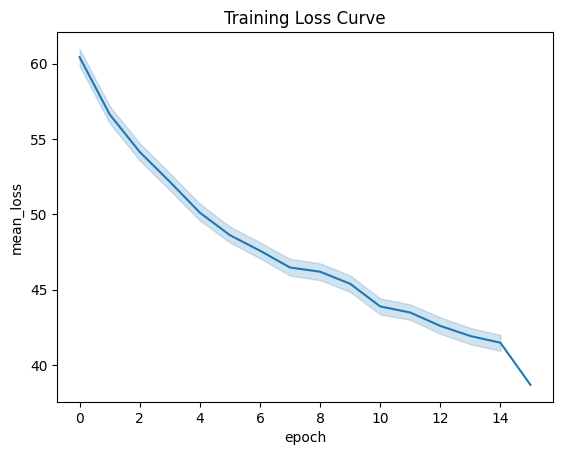

In [16]:
# Get the final model after tuning is complete
model = operation.result()

# Extract tuning snapshots for analysis
snapshots = pd.DataFrame(model.tuning_task.snapshots)

# Plot the loss curve
sns.lineplot(data=snapshots, x='epoch', y='mean_loss').set(title='Training Loss Curve')

### Testing the Model after Fine Tuning Using Prompt Engineering

In [ ]:
def ask_model_question(question):
    model = genai.GenerativeModel(model_name='tunedModels/tvqa-castle-friends-gemini-6')

    prompt = (
            f"You are an expert assistant. I fine tuned you on the subtitles of two TV shows named 'Castle' and 'Friends'. Your task is to answer the questions based solely on the content you are fine tuned on.\n\n"
            f"If you cannot find the answer in the data, you must say 'I don't have an answer to your question.\n\n"
            f"Question: {question}\n\n"
    )
    result = model.generate_content(prompt)
    return result.text